# WorkShop 5 - TEXT CLASSIFICATION USING NAIVE BAYES
Date: March 5, 2021

Student name: Xinwei Fan (920863200)

Reference: 

1. https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73

2. http://www.nltk.org/api/nltk.html?highlight=probability%20probdist

In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud 
from math import log, sqrt
from nltk.corpus import stopwords
#from nltk.probability import ConditionalFreqDist
from collections import Counter
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


## 1. Create a toy labeled dataset
This dataset have 10 sentences with a class label associated with each datapoint. There should be at least 2 classes: spam vs ham.

In [2]:
dataset = pd.read_csv('spam-small.csv', encoding='latin-1')
print(dataset)

     v1                                                 v2
0  spam  Had your mobile 11 months or more? U R entitle...
1  spam  07732584351 - Rodger Burns - MSG = We tried to...
2  spam  Congrats! 1 year special cinema pass for 2 is ...
3  spam  You'll not rcv any more msgs from the chat svc...
4  spam  FreeMsg Why haven't you replied to my text? I'...
5   ham                      Ok lar... Joking wif u oni...
6   ham  U dun say so early hor... U c already then say...
7   ham                        Oh ok...i'm watching here:)
8   ham  I'm back &amp; we're packing the car now, I'll...
9   ham  Hello! How's you and how did saturday go? I wa...


### 1.1 Visualizing spam and ham dataset

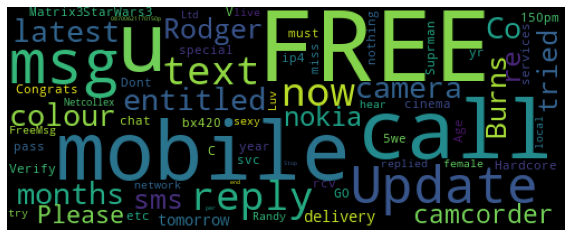

In [3]:
spam_word = ' '.join(list(dataset[dataset['v1'] == 'spam']['v2']))
spam_wc = WordCloud(width = 500, height = 200).generate(spam_word)
plt.figure(figsize = (10, 8))
plt.imshow(spam_wc)
plt.axis('off')
plt.show()

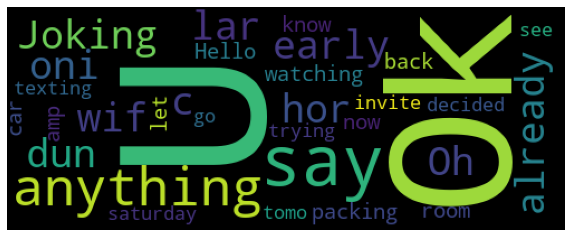

In [4]:
ham_word = ' '.join(list(dataset[dataset['v1'] == 'ham']['v2']))
ham_wc = WordCloud(width = 500, height = 200).generate(ham_word)
plt.figure(figsize = (10, 8))
plt.imshow(ham_wc)
plt.axis('off')
plt.show()

## 2. Use Naive Bayes to do text classification

### 2.1 Calculate the prior probabilities

In [5]:
def get_prior(dataset):
    num_spam = len(dataset[dataset['v1'] == 'spam'])
    num_ham = len(dataset[dataset['v1'] == 'ham'])
    p_spam = num_spam / len(dataset)
    p_ham = num_ham / len(dataset)
    return p_spam, p_ham

p_spam, p_ham = get_prior(dataset)
print("the spam prior = ", p_spam)
print("the ham prior = ", p_ham)

the spam prior =  0.5
the ham prior =  0.5


### 2.2 Calculate the conditional probabilities
Calculate the conditional probabilities of each word (with respect to both the categories) in the dataset.

In [6]:
# Preprocessing: prepare token
def process_word(dataset, category, rm_punctuation=False, stemming=False, rm_stopwords=False):
    if category == "spam": 
        message = ' '.join(list(dataset[dataset['v1'] == 'spam']['v2']))
    
    elif category == "ham":
        message = ' '.join(list(dataset[dataset['v1'] == 'ham']['v2']))
    
    elif category == "input":
        message = ' '. join(dataset.split())
    
    else:
        return "Error: the type of category is wrong"
    
    # 1. lowercase
    message = message.lower()
    
    # 2. remove all punctuation
    if rm_punctuation: 
        tokenizer = nltk.RegexpTokenizer(r"\w+")
        words = tokenizer.tokenize(message)
     
    # 3. remove same meaning words (stemming)
    # The words like ‘go’, ‘goes’, ‘going’ indicate the same activity. 
    # so we can replace all these words by a single word ‘go’.
    if stemming:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
        
    # 4. remove stop words 
    if rm_stopwords:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw] 
    return words

In [7]:
spam_words = process_word(dataset, "spam", rm_punctuation=True)
ham_words = process_word(dataset, "ham", rm_punctuation=True)
# print(spam_words)
print(ham_words)

['ok', 'lar', 'joking', 'wif', 'u', 'oni', 'u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say', 'oh', 'ok', 'i', 'm', 'watching', 'here', 'i', 'm', 'back', 'amp', 'we', 're', 'packing', 'the', 'car', 'now', 'i', 'll', 'let', 'you', 'know', 'if', 'there', 's', 'room', 'hello', 'how', 's', 'you', 'and', 'how', 'did', 'saturday', 'go', 'i', 'was', 'just', 'texting', 'to', 'see', 'if', 'you', 'd', 'decided', 'to', 'do', 'anything', 'tomo', 'not', 'that', 'i', 'm', 'trying', 'to', 'invite', 'myself', 'or', 'anything']


In [8]:
def conditional_freq(ham_words, spam_words):
    all_words = ham_words + spam_words
    num_token = len(Counter(all_words))

    num_ham = len(ham_words)
    num_spam = len(spam_words)
    
    dict_ham = {word:(ham_words.count(word)+1)/(num_ham + num_token) for word in all_words}
    dict_spam = {word:(spam_words.count(word)+1)/(num_spam + num_token) for word in all_words}
    
    return dict_ham, dict_spam

In [9]:
# test on conditional frequency
dict_ham, dict_spam = conditional_freq(ham_words, spam_words)
print("The conditional frequency distributions for word 'free': ", dict_spam['free'])
print("The conditional frequency distributions for word 'ok': ", dict_ham['ok'])

The conditional frequency distributions for word 'free':  0.023026315789473683
The conditional frequency distributions for word 'ok':  0.013100436681222707


## 3. Prediction
Using the probabilities calculated before and Naive Bayes classification, predict the class of the input sentence. (Calculate the probability of the input sentence being in different classes. The class having the highest probability will be the output class.)

In [10]:
def prediction(message, dict_ham, dict_spam, p_spam, p_ham):
    # pre-process
    message = process_word(message, "input", rm_punctuation=True)
    
    # considering the message is a spam
    probability_spam = p_spam
    for word in message:
        probability_spam *= dict_spam[word]
    print('probability_spam', probability_spam)
    
    # considering the message is a ham
    probability_ham = p_ham
    for word in message:
        probability_ham *= dict_ham[word]
    print('probability_ham', probability_ham)
    
    if probability_ham == probability_spam:
        return "hard to recognize"
    elif probability_ham > probability_spam:
        return "Prediction: ham message!"
    else:
        return "Prediction: spam message!"

In [11]:
test1 = "Ok... you say ok"
print(prediction(test1, dict_ham, dict_spam, p_spam, p_ham))

probability_spam 2.3417237532707695e-10
probability_ham 1.9635946061904854e-08
Prediction: ham message!


In [12]:
test2 = "we call you FREE!"
print(prediction(test2, dict_ham, dict_spam, p_spam, p_ham))

probability_spam 1.6392066272895388e-08
probability_ham 1.454514523104063e-09
Prediction: spam message!


## Varification 2
![](./slide_NB.png)

In [13]:
dataset = pd.read_csv('slides_example.csv', encoding='latin-1')
print(dataset)

     v1                        v2
0  spam   Chinese Beijing Chinese
1  spam  Chinese Chinese Shanghai
2  spam             Chinese Macao
3   ham       Tokyo Japan Chinese


In [14]:
p_spam, p_ham = get_prior(dataset)
print("the spam prior = ", p_spam)
print("the ham prior = ", p_ham)

the spam prior =  0.75
the ham prior =  0.25


In [15]:
spam_words = process_word(dataset, "spam", rm_punctuation=True)
ham_words = process_word(dataset, "ham", rm_punctuation=True)
print(spam_words)
print(ham_words)

['chinese', 'beijing', 'chinese', 'chinese', 'chinese', 'shanghai', 'chinese', 'macao']
['tokyo', 'japan', 'chinese']


In [16]:
dict_ham, dict_spam = conditional_freq(ham_words, spam_words)
print(dict_ham)
print(dict_spam)

{'tokyo': 0.2222222222222222, 'japan': 0.2222222222222222, 'chinese': 0.2222222222222222, 'beijing': 0.1111111111111111, 'shanghai': 0.1111111111111111, 'macao': 0.1111111111111111}
{'tokyo': 0.07142857142857142, 'japan': 0.07142857142857142, 'chinese': 0.42857142857142855, 'beijing': 0.14285714285714285, 'shanghai': 0.14285714285714285, 'macao': 0.14285714285714285}


In [17]:
test = "Chinese Chinese Chinese Tokyo Japan"
print(prediction(test, dict_ham, dict_spam, p_spam, p_ham))

probability_spam 0.00030121377997263036
probability_ham 0.00013548070246744226
Prediction: spam message!
